In [ ]:
%%capture
!pip install datasets
!pip install pip3-autoremove
!pip-autoremove torch torchvision torchaudio -y
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

# Install Flash Attention 2 for GPUs with CUDA capability >= 8 (e.g., A100, H100)
import torch
if torch.cuda.get_device_capability()[0] >= 8:
    !pip install --no-deps packaging ninja einops "flash-attn>=2.6.3"  # Flash Attention 2 for faster training

In [ ]:
import torch  # For GPU operations and tensor computations
import os     # For file and directory operations
import re     # For regular expressions
from typing import List, Literal, Optional  # For type hints
from datasets import load_dataset
from unsloth import FastLanguageModel, is_bfloat16_supported  # For efficient model loading and training
from trl import KTOConfig, KTOTrainer                         # For KTO training

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", "en")
train_dataset = dataset['train']
# train_subset = train_dataset.select(range(1000))
train_subset = train_dataset

In [ ]:
len(train_dataset)

25371

In [ ]:
train_subset[0]

{'Question': 'A 61-year-old woman with a long history of involuntary urine loss during activities like coughing or sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based on these findings, what would cystometry most likely reveal about her residual volume and detrusor contractions?',
 'Complex_CoT': "Okay, let's think about this step by step. There's a 61-year-old woman here who's been dealing with involuntary urine leakages whenever she's doing something that ups her abdominal pressure like coughing or sneezing. This sounds a lot like stress urinary incontinence to me. Now, it's interesting that she doesn't have any issues at night; she isn't experiencing leakage while sleeping. This likely means her bladder's ability to hold urine is fine when she isn't under physical stress. Hmm, that's a clue that we're dealing with something related to pressure rather than a bladder muscle problem. \n\nThe fact that she underwent a Q-tip test is intriguing too. This 

In [ ]:
# Set basic parameters
max_seq_length = 4096  # Maximum sequence length the model can handle
dtype = None           # Auto-detect data type (float16 for Tesla T4/V100, bfloat16 for Ampere+ GPUs)
load_in_4bit = True    # Use 4-bit quantization to reduce memory usage
# Load the pre-trained model and tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/DeepSeek-R1-Distill-Qwen-1.5B-unsloth-bnb-4bit",
    max_seq_length=max_seq_length,  # Set max sequence length
    dtype=dtype,                    # Auto-detect data type
    load_in_4bit=load_in_4bit,      # Enable 4-bit quantization
    # token="hf_...",                # Use this if accessing gated models (e.g., LLaMA 2)
)
# Add a default chat template if missing
if tokenizer.chat_template is None:
    DEFAULT_CHAT_TEMPLATE = f"""
    <｜begin▁of▁sentence｜>
    You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
    Below is an instruction that describes a task, paired with an input that provides further context.
    Write a response that appropriately completes the request.
    Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.
    <｜User｜>
    {{question}}
    <｜Assistant｜>
    <think>
    {{complex_cot}}
    </think>

    {{answer}}
    <｜end▁of▁sentence｜>
    """
    tokenizer.chat_template = DEFAULT_CHAT_TEMPLATE  # Apply the default template

==((====))==  Unsloth 2025.2.15: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.81G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/6.78k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

In [ ]:
prompt_template = f"""
<｜begin▁of▁sentence｜>
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.
<｜User｜>
{{question}}
<｜Assistant｜>
<think>
{{complex_cot}}
</think>

{{answer}}
<｜end▁of▁sentence｜>
"""

In [ ]:
import random
def apply_chat_template(sample):

    use_cot = True #random.choice([True, False])  # Randomly assign reasoning or direct response
    prompt = f"Question: {sample['Question']}\n\n"
    prompt += "Answer: Let's think step by step.\n\n" if use_cot else "Answer: "

    # Return the formatted prompt and expected response
    return {
        "prompt": prompt,
        "completion": sample['Complex_CoT'] if use_cot else sample['Response'],
        "label": True
    }


    return sample

In [ ]:
# Apply the chat template to the dataset using .map()
train_subset = train_subset.map(apply_chat_template) # Here we are adding the column text to the train dataset
# train_subset = train_subset.rename_column("text","prompt") # rename text to prompt so the kto trainer can use it


Map:   0%|          | 0/25371 [00:00<?, ? examples/s]

In [ ]:
if "text" in train_subset.column_names:
  train_subset = train_subset.rename_column("text","prompt")

In [ ]:
# Configure LoRA (Low-Rank Adaptation) for parameter-efficient fine-tuning
model = FastLanguageModel.get_peft_model(
    model,
    r=16,  # LoRA rank
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],  # Target layers
    lora_alpha=16,      # LoRA scaling factor
    lora_dropout=0,     # Dropout for LoRA layers
    bias="none",        # No bias for LoRA
    use_gradient_checkpointing="unsloth",  # Enable gradient checkpointing for memory efficiency
    random_state=3407,  # Random seed for reproducibility
)

Unsloth 2025.2.15 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
# for name, param in model.named_parameters():
#     if "q_proj" in name:
#         print(f"LoRA Layer: {name}, Trainable: {param.requires_grad}")

In [ ]:
layer_name = "base_model.model.model.layers.27.self_attn.q_proj.lora_B.default.weight"
initial_weights = model.state_dict()[layer_name].clone()
initial_weights.shape

torch.Size([1536, 16])

In [ ]:
from transformers import TrainerCallback
class MemoryManagementCallback(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        # 1. Delete the inputs (batch) and outputs
        if "inputs" in kwargs:  # Check if "inputs" is present (it might not be in all calls)
            inputs = kwargs["inputs"]
            if isinstance(inputs, dict):  # Handle dictionary inputs
                for k, v in inputs.items():
                    if isinstance(v, torch.Tensor):
                        del v
            elif isinstance(inputs, torch.Tensor):  # Handle tensor inputs
                del inputs

        if "outputs" in kwargs:
            outputs = kwargs["outputs"]
            if isinstance(outputs, dict):  # Handle dictionary outputs
                for k, v in outputs.items():
                    if isinstance(v, torch.Tensor):
                        del v
            elif isinstance(outputs, torch.Tensor):  # Handle tensor inputs
                del outputs

        # 2. Empty CUDA cache
        torch.cuda.empty_cache()

        # 3. Print memory stats (optional - for monitoring)
        if state.global_step % 100 == 0:  # Print every 10 steps
            print(f"Step: {state.global_step}, Loss: {state.log_history[-1]['loss']:.4f}")
            print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
            print(f"Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
            allocated_memory = torch.cuda.memory_allocated()
            reserved_memory = torch.cuda.memory_reserved()
            free_memory = reserved_memory - allocated_memory
            print(f"Free: {free_memory / 1024**3:.2f} GB")



In [ ]:
# Set up the KTO trainer with training arguments
kto_trainer = KTOTrainer(
    model=model,
    args=KTOConfig(
        per_device_train_batch_size=4,    # Batch size per GPU
        gradient_accumulation_steps=2,    # Gradient accumulation for larger effective batch size
        num_train_epochs=1,               # Number of training epochs
        learning_rate=5e-7,               # Learning rate
        fp16=not is_bfloat16_supported(), # Use FP16 if BF16 is not supported
        bf16=is_bfloat16_supported(),     # Use BF16 if supported
        output_dir="outputs",             # Directory to save outputs
        logging_steps=1,                  # Log training progress every step
        optim="adamw_8bit",               # Use 8-bit AdamW optimizer
        weight_decay=0.01,                # Weight decay for regularization
        lr_scheduler_type="cosine",       # Cosine learning rate scheduler
        warmup_ratio=0.1,                 # Warmup ratio for learning rate
        seed=42,                          # Random seed
        report_to="none",                 # Disable external logging (e.g., WandB)
    ),
    train_dataset=train_subset,           # Training dataset
    processing_class=tokenizer,           # Tokenizer for processing data
    callbacks = [MemoryManagementCallback()]
    # column_mapping={"text": "prompt"} # Tell the kto trainer that the column is called prompt
)

# Print GPU memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

# Train the model
kto_trainer.train()


/content/unsloth_compiled_cache/UnslothKTOTrainer.py:620: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your KTOConfig we have set it for you, but you should do it yourself in the future.
  warnings.warn(


Extracting prompt from train dataset (num_proc=12):   0%|          | 0/25371 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=12):   0%|          | 0/25371 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=12):   0%|          | 0/25371 [00:00<?, ? examples/s]

Processing tokenized train dataset (num_proc=12):   0%|          | 0/25371 [00:00<?, ? examples/s]

Extracting KL train dataset (num_proc=12):   0%|          | 0/25371 [00:00<?, ? examples/s]

Processing tokenized train KL dataset (num_proc=12):   0%|          | 0/25371 [00:00<?, ? examples/s]

/content/unsloth_compiled_cache/UnslothKTOTrainer.py:825: UserWarning: You have different amounts of desirable/positive and undesirable/negative examples but the weights on the desirable and undesirable losses don't seem to be in an ideal range. Based on your data, we recommend EITHER desirable_weight in [0.0, 0.0] or undesirable_weight in [19075.94, 25371.0] (but NOT BOTH). See the documentation on how to optimally set these weights.
  warnings.warn(


GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
1.785 GB of memory reserved.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 25,371 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 3,171
 "-____-"     Number of trainable parameters = 18,464,768


Step,Training Loss,rewards / chosen_sum,rewards / rejected_sum,kl,logps / chosen_sum,logits / chosen_sum,count / chosen,logps / rejected_sum,logits / rejected_sum,count / rejected,logits / chosen,logits / rejected
1,0.500000,0,0,0.000000,0,0,0,0,0,0,-51854604.000000,0
2,0.500000,No Log,No Log,0.000000,No Log,No Log,No Log,No Log,No Log,No Log,-78109920.000000,No Log
3,0.500000,No Log,No Log,0.000000,No Log,No Log,No Log,No Log,No Log,No Log,-54873152.000000,No Log
4,0.500000,No Log,No Log,0.000000,No Log,No Log,No Log,No Log,No Log,No Log,-25161104.000000,No Log
5,0.500000,No Log,No Log,0.000000,No Log,No Log,No Log,No Log,No Log,No Log,-55195556.000000,No Log
6,0.499200,No Log,No Log,0.000000,No Log,No Log,No Log,No Log,No Log,No Log,-67599264.000000,No Log
7,0.499800,No Log,No Log,0.000000,No Log,No Log,No Log,No Log,No Log,No Log,-68693512.000000,No Log
8,0.505900,No Log,No Log,0.084000,No Log,No Log,No Log,No Log,No Log,No Log,-77219104.000000,No Log
9,0.509200,No Log,No Log,0.061836,No Log,No Log,No Log,No Log,No Log,No Log,-33951164.000000,No Log
10,0.501200,No Log,No Log,0.000000,No Log,No Log,No Log,No Log,No Log,No Log,-59740680.000000,No Log


Step: 100, Loss: 0.5061
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 200, Loss: 0.5023
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 300, Loss: 0.5241
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 400, Loss: 0.5045
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 500, Loss: 0.5023
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 600, Loss: 0.4980
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 700, Loss: 0.4986
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 800, Loss: 0.4877
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 900, Loss: 0.5589
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 1000, Loss: 0.4667
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 1100, Loss: 0.4646
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 1200, Loss: 0.4898
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 1300, Loss: 0.4435
Allocated: 1.91 GB
Reserved: 2.04 GB
Free: 0.14 GB
Step: 1400, Loss: 0.3

TrainOutput(global_step=3171, training_loss=0.45362852251574803, metrics={'train_runtime': 4680.5778, 'train_samples_per_second': 5.42, 'train_steps_per_second': 0.677, 'total_flos': 0.0, 'train_loss': 0.45362852251574803, 'epoch': 0.9998423458931105})

In [ ]:
import sys

def check_gpu_usage():
    print("Checking GPU usage...")
    sys.stdout.flush()  # Forces output display
    print(torch.cuda.memory_allocated() / 1e9, "GB allocated")
    sys.stdout.flush()
    print(torch.cuda.memory_reserved() / 1e9, "GB reserved")
    sys.stdout.flush()

check_gpu_usage()


Checking GPU usage...
2.045855232 GB allocated
2.195718144 GB reserved


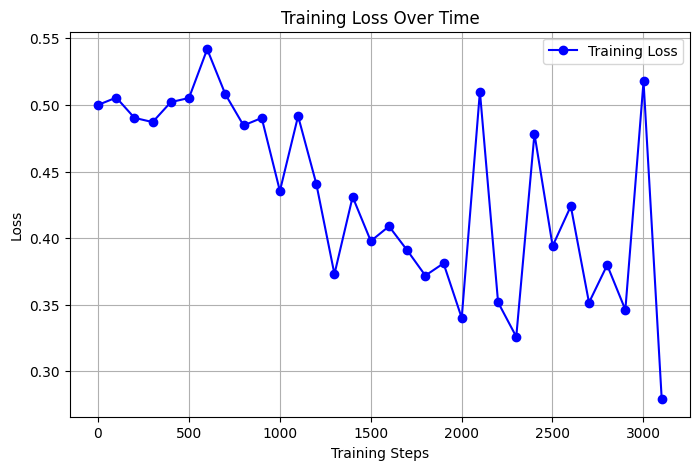

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from logs
loss_values = []
steps = []

for log in kto_trainer.state.log_history[::100]:
    if "loss" in log:  # Ensure the log contains loss values
        loss_values.append(log["loss"])
        steps.append(log["step"])  # Track steps for x-axis

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(steps, loss_values, label="Training Loss", color="blue", marker="o")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()


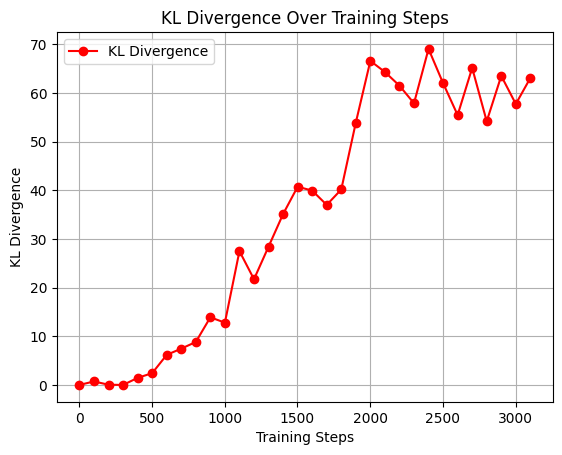

In [ ]:
import matplotlib.pyplot as plt

kl_values = []
steps = []

for log in kto_trainer.state.log_history[::100]:
    if "kl" in log:
        kl_values.append(log["kl"])
        steps.append(log["step"])

plt.plot(steps, kl_values, label="KL Divergence", color="red", marker="o")
plt.xlabel("Training Steps")
plt.ylabel("KL Divergence")
plt.title("KL Divergence Over Training Steps")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from unsloth.chat_templates import get_chat_template
from transformers import TextStreamer

In [ ]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml",
    mapping = {"role": "role", "content": "content", "user": "user", "assistant": "assistant"},
)

Unsloth: Will map <|im_end|> to EOS = <｜end▁of▁sentence｜>.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


In [ ]:
FastLanguageModel.for_inference(model)
def generate_response(message):
    print("\n" + "="*50 + "\nQUESTION:\n" + "="*50)
    print(message + "\n")
    print("-"*50 + "\nRESPONSE:\n" + "-"*50)

    messages = [{"content": message, "role": "user"}]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True,
        return_tensors = "pt"
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_special_tokens=True, skip_prompt=True)
    outputs = model.generate(
        input_ids=inputs,
        streamer=text_streamer,
        temperature=0.1,      # Sampling temperature
        max_new_tokens=1024,  # Maximum tokens to generate
        use_cache=True        # Use caching for faster generation
    )
    return outputs


In [ ]:
questions = [
    # "A 3-week-old child has been diagnosed with late onset perinatal meningitis, and the CSF culture shows gram-positive bacilli. What characteristic of this bacterium can specifically differentiate it from other bacterial agents?",
    "A 2-month-old infant presents with fever, irritability, and a bulging fontanelle. CSF analysis reveals gram-positive cocci in chains. What laboratory test can help distinguish this pathogen from other gram-positive cocci?",
    "A 5-day-old neonate is diagnosed with bacterial meningitis, and the causative organism is a gram-negative rod. What virulence factor is primarily responsible for this pathogen’s ability to cross the blood-brain barrier?",
    "A 67-year-old immunocompromised patient develops meningitis. CSF culture reveals gram-positive bacilli. What unique motility characteristic helps differentiate this pathogen from other gram-positive bacilli?",
    "A 28-year-old pregnant woman presents with flu-like symptoms and is found to have a bacteremia caused by a gram-positive rod. What environmental condition can this pathogen survive in that distinguishes it from other similar bacteria?",
    "A newborn presents with sepsis, and blood cultures grow a gram-positive bacillus. What distinguishing feature of this organism allows it to persist in refrigerated dairy products?"]

# Generate responses for each question
for question in questions:
    generate_response(question)
    break



QUESTION:
A 2-month-old infant presents with fever, irritability, and a bulging fontanelle. CSF analysis reveals gram-positive cocci in chains. What laboratory test can help distinguish this pathogen from other gram-positive cocci?

--------------------------------------------------
RESPONSE:
--------------------------------------------------
A 2-month-old infant presents with fever, irritability, and a bulging fontanelle. CSF analysis reveals gram-positive cocci in chains. What laboratory test can help distinguish this pathogen from other gram-positive cocci?

>
<|im_start|>assistant>
Okay, so I need to figure out what laboratory test can help distinguish this pathogen from other gram-positive cocci. Let me start by recalling what I know about these organisms.

First, gram-positive cocci are a group of bacteria that have a cell wall composed of two or more types of glycosidic linkages. These linkages are usually carbohydrate-based, which means they're often found in the cell walls of

In [ ]:
from huggingface_hub import login
login()

In [ ]:
# Save model and tokenizer locally
save_directory = "./finetuned-DeepSeek-R1-Distill-Qwen-1.5B-medical-o1-reasoning-SFT_2e-4"
model.save_pretrained(save_directory, safe_serialization=True)
tokenizer.save_pretrained(save_directory)

In [ ]:
from huggingface_hub import create_repo
repo_name = "finetuned-DeepSeek-R1-Distill-Qwen-1.5B-medical-o1-reasoning-SFT_2e-4"  # Change this to your preferred repo name
create_repo(repo_name, private=False)  # Set private=False if you want it public

In [ ]:
model.push_to_hub("arjun7622/finetuned-DeepSeek-R1-Distill-Qwen-1.5B-medical-o1-reasoning-SFT_2e-4")
tokenizer.push_to_hub("arjun7622/finetuned-DeepSeek-R1-Distill-Qwen-1.5B-medical-o1-reasoning-SFT_2e-4")

In [ ]:
# del model
# del base_model

In [ ]:

# Set basic parameters
max_seq_length = 4096  # Maximum sequence length the model can handle
dtype = None           # Auto-detect data type (float16 for Tesla T4/V100, bfloat16 for Ampere+ GPUs)
load_in_4bit = True    # Use 4-bit quantization to reduce memory usage
# Load the pre-trained model and tokenizer

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name= "arjun7622/finetuned-DeepSeek-R1-Distill-Qwen-1.5B-medical-o1-reasoning-SFT_2e-4",
    # model_name="unsloth/DeepSeek-R1-Distill-Qwen-1.5B-unsloth-bnb-4bit
    max_seq_length=max_seq_length,  # Set max sequence length
    dtype=dtype,                    # Auto-detect data type
    load_in_4bit=load_in_4bit,      # Enable 4-bit quantization
    # token="hf_...",                # Use this if accessing gated models (e.g., LLaMA 2)
)



==((====))==  Unsloth 2025.2.15: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.2.15 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/DeepSeek-R1-Distill-Qwen-1.5B-unsloth-bnb-4bit",
    max_seq_length=max_seq_length,  # Set max sequence length
    dtype=dtype,                    # Auto-detect data type
    load_in_4bit=load_in_4bit,      # Enable 4-bit quantization
    # token="hf_...",                # Use this if accessing gated models (e.g., LLaMA 2)
)

# Configure LoRA (Low-Rank Adaptation) for parameter-efficient fine-tuning
base_model = FastLanguageModel.get_peft_model(
    base_model,
    r=16,  # LoRA rank
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],  # Target layers
    lora_alpha=16,      # LoRA scaling factor
    lora_dropout=0,     # Dropout for LoRA layers
    bias="none",        # No bias for LoRA
    use_gradient_checkpointing="unsloth",  # Enable gradient checkpointing for memory efficiency
    random_state=3407,  # Random seed for reproducibility
)

==((====))==  Unsloth 2025.2.15: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.0. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
# base_model.model.model.layers.27.self_attn.q_proj.lora_B.default.weight
layer_name = "base_model.model.model.layers.27.self_attn.q_proj.lora_B.default.weight"

In [ ]:
import torch

# Compare a specific layer


base_weights = base_model.state_dict()[layer_name]
finetuned_weights = model.state_dict()["base_model.model.model.layers.27.self_attn.q_proj.lora_B.default.weight"]

# Check if they are different

print(torch.equal(base_weights, finetuned_weights))  # Should print False if fine-tuning worked
print(base_weights.shape, finetuned_weights.shape)

False
torch.Size([1536, 16]) torch.Size([1536, 16])


In [ ]:
FastLanguageModel.for_inference(base_model)
def generate_response(message):
    print("\n" + "="*50 + "\nQUESTION:\n" + "="*50)
    print(message + "\n")
    print("-"*50 + "\nRESPONSE:\n" + "-"*50)

    messages = [{"content": message, "role": "user"}]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True,
        return_tensors = "pt"
    ).to("cuda")

    text_streamer = TextStreamer(base_tokenizer, skip_special_tokens=True, skip_prompt=True)
    outputs = base_model.generate(
        input_ids=inputs,
        streamer=text_streamer,
        temperature=0.1,      # Sampling temperature
        max_new_tokens=1024,  # Maximum tokens to generate
        use_cache=True        # Use caching for faster generation
    )
    return outputs


In [ ]:
# generate_response(questions[1])

# Computing KL Divergence Between the Base & Fine-Tuned Models

In [ ]:
prompt = questions[1]
# "A 3-week-old child has been diagnosed with late-onset perinatal meningitis. What is the most likely bacterial cause?"

# Tokenize the prompt
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")  # Move to GPU

# Forward pass through both models
with torch.no_grad():
    base_outputs = base_model(**inputs)
    finetuned_outputs = model(**inputs)

# Get logits from both models
base_logits = base_outputs.logits
finetuned_logits = finetuned_outputs.logits

In [ ]:
base_logits.shape, finetuned_logits.shape

(torch.Size([1, 47, 151936]), torch.Size([1, 47, 151936]))

In [ ]:
import torch
import torch.nn.functional as F

def compute_kl_divergence(base_logits, finetuned_logits):
    """
    Compute KL divergence between base and fine-tuned model outputs.
    """
    # Convert logits to probability distributions
    p = F.log_softmax(base_logits, dim=-1)  # Base model (log prob)
    q = F.softmax(finetuned_logits, dim=-1)  # Fine-tuned model (prob)

    # Compute KL divergence
    kl_div = F.kl_div(p, q, reduction="batchmean")  # 'batchmean' ensures stable computation

    return kl_div

# Example usage:

kl_value = compute_kl_divergence(base_logits, finetuned_logits)
print(f"KL Divergence: {kl_value.item()}")


KL Divergence: 0.55078125


In [ ]:
# for idx, (name, param) in enumerate(model.named_parameters()):
#     if "q_proj" in name:
#       print(f"Layer {idx}: {name} | Shape: {param.shape}")


In [ ]:
def analyze_kl_divergence(prompt, base_model, fine_tuned_model, tokenizer):
    """Analyzes KL divergence at each token in the generated sequence."""
    inputs = tokenizer(prompt, return_tensors="pt").to(base_model.device)


    with torch.no_grad():
        base_outputs = base_model(**inputs, output_hidden_states=False)
        fine_tuned_outputs = fine_tuned_model(**inputs, output_hidden_states=False)

    base_logits = base_outputs.logits
    fine_tuned_logits = fine_tuned_outputs.logits

    print("BASE LOGITS SHAPE :", base_logits.shape)
    print("FINE TUNED LOGITS SHAPE :", fine_tuned_logits.shape)
    kl_divergences = []
    for i in range(base_logits.size(1)):
        kl = compute_kl_divergence(base_logits[:, i, :], fine_tuned_logits[:, i, :])
        kl_divergences.append(kl.item())

    print("LEN KL Divergence :", len(kl_divergences))
    return kl_divergences, inputs['input_ids']

prompt = questions[1]
kl_divs, input_ids = analyze_kl_divergence(prompt, base_model, model, base_tokenizer)

print("KL Divergences at each token:", kl_divs)



BASE LOGITS SHAPE : torch.Size([1, 47, 151936])
FINE TUNED LOGITS SHAPE : torch.Size([1, 47, 151936])
LEN KL Divergence : 47
KL Divergences at each token: [-0.0020599365234375, 0.01434326171875, 0.01251220703125, 0.006256103515625, 0.0101318359375, 0.0020294189453125, 0.0038909912109375, 0.0172119140625, 0.01220703125, 0.00018596649169921875, 0.0103759765625, 0.00537109375, 0.0005645751953125, 0.022705078125, 0.01275634765625, 0.0179443359375, 0.0157470703125, 0.00958251953125, 0.00421142578125, 0.00921630859375, 0.01348876953125, 0.01708984375, 0.00433349609375, 0.006072998046875, 0.004608154296875, 0.03076171875, 0.0279541015625, 0.00701904296875, 0.002532958984375, 0.01458740234375, 0.0135498046875, 0.01007080078125, 1.3828277587890625e-05, 0.0242919921875, 0.0242919921875, 0.0047607421875, 0.005828857421875, 0.031494140625, 0.002288818359375, 0.03369140625, 0.01141357421875, 0.0224609375, 0.000949859619140625, 0.0047607421875, 0.002685546875, 0.0201416015625, 0.0234375]


In [ ]:
import matplotlib.pyplot as plt

<ipython-input-19-da8dc6653fcc>:8: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to make room for label rotation
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


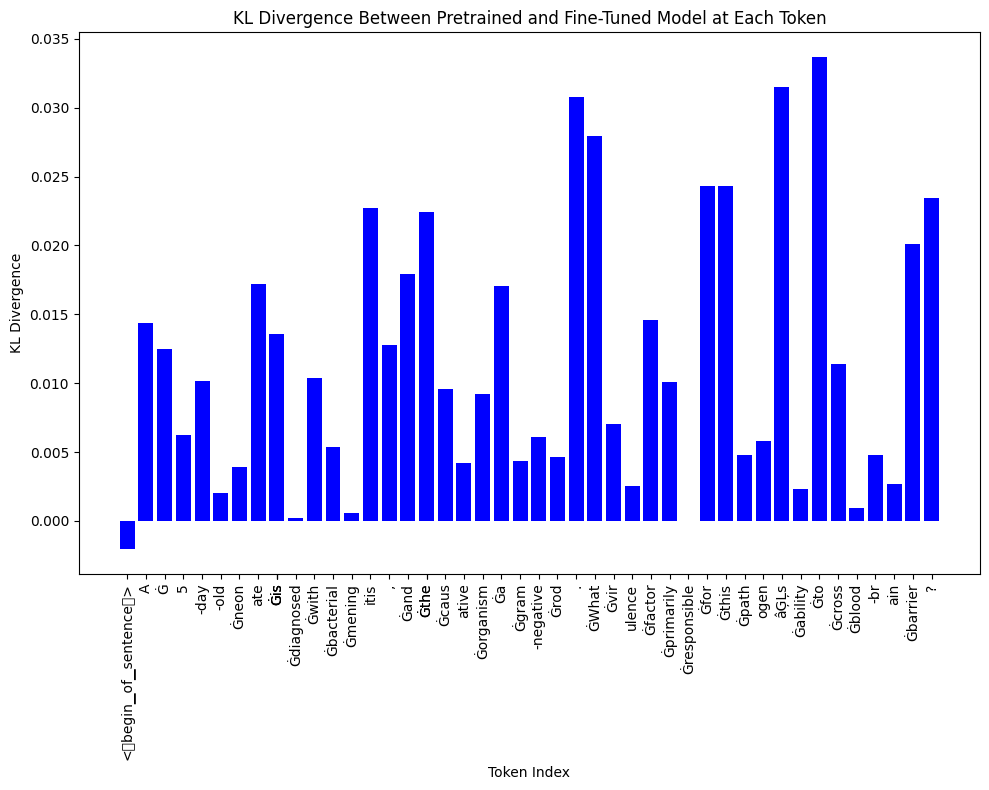

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
plt.figure(figsize=(10, 8))
plt.bar(tokens, kl_divs, color='blue')
plt.xlabel('Token Index')
plt.ylabel('KL Divergence')
plt.title('KL Divergence Between Pretrained and Fine-Tuned Model at Each Token')
plt.xticks(tokens, rotation=90)  # Rotate labels to avoid overlap
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
inputs = tokenizer(prompt, return_tensors="pt").to(base_model.device)

with torch.no_grad():
    base_generated = base_model.generate(
        inputs.input_ids, max_new_tokens=50, do_sample=True, temperature=0.7
    )
    finetuned_generated = model.generate(
        inputs.input_ids, max_new_tokens=50, do_sample=True, temperature=0.7
    )

base_text = tokenizer.decode(base_generated[0], skip_special_tokens=True)
finetuned_text = tokenizer.decode(finetuned_generated[0], skip_special_tokens=True)

print("Base Model Output:", base_text)
print("Fine-tuned Model Output:", finetuned_text)


# Tokenize generated text
base_inputs = tokenizer(base_text, return_tensors="pt").to("cuda")
finetuned_inputs = tokenizer(finetuned_text, return_tensors="pt").to("cuda")

# Get logits for generated tokens
with torch.no_grad():
    base_outputs = base_model(**base_inputs)
    finetuned_outputs = model(**finetuned_inputs)

base_logits = base_outputs.logits
finetuned_logits = finetuned_outputs.logits

# Get the shorter sequence length
min_seq_len = min(base_logits.shape[1], finetuned_logits.shape[1])

# Truncate the logits tensors
base_logits = base_logits[:, :min_seq_len, :]
finetuned_logits = finetuned_logits[:, :min_seq_len, :]


kl_value = compute_kl_divergence(base_logits, finetuned_logits)
print(f"\n\n\nKL Divergence (Generated Tokens): {kl_value.item()}")

Base Model Output: A 5-day-old neonate is diagnosed with bacterial meningitis, and the causative organism is a gram-negative rod. What virulence factor is primarily responsible for this pathogen’s ability to cross the blood-brain barrier? The answer should be... .......
</think>

A gram-negative rod is a pathogen that can cause bacterial meningitis. The virulence factor primarily responsible for this pathogen’s ability to cross the blood-brain barrier is **hemagglut
Fine-tuned Model Output: A 5-day-old neonate is diagnosed with bacterial meningitis, and the causative organism is a gram-negative rod. What virulence factor is primarily responsible for this pathogen’s ability to cross the blood-brain barrier? Provide a step-by-step explanation of how you arrived at the answer, including all the steps and assumptions made.
</think>

To determine the virulence factor primarily responsible for the pathogen's ability to cross the blood-brain barrier (BBA), we



KL Divergence (Generated Token

Base Model Output: A 5-day-old neonate is diagnosed with bacterial meningitis, and the causative organism is a gram-negative rod. What virulence factor is primarily responsible for this pathogen’s ability to cross the blood-brain barrier? What is the primary source of this virulence factor?

A) ...
B) ...
C) ...
D) ...

The user is a student.
The student is a student.
The student is trying to understand this question and find the solution.

So,
Fine-tuned Model Output: A 5-day-old neonate is diagnosed with bacterial meningitis, and the causative organism is a gram-negative rod. What virulence factor is primarily responsible for this pathogen’s ability to cross the blood-brain barrier? The pathogen has not been treated with any antiviral drug, and the blood-brain barrier is very resistant to it.
The answer options are:
A) Hydroxyethyl group
B) Hydroxypropyl group
C) Hydroxy
LEN KL Divergence: 97


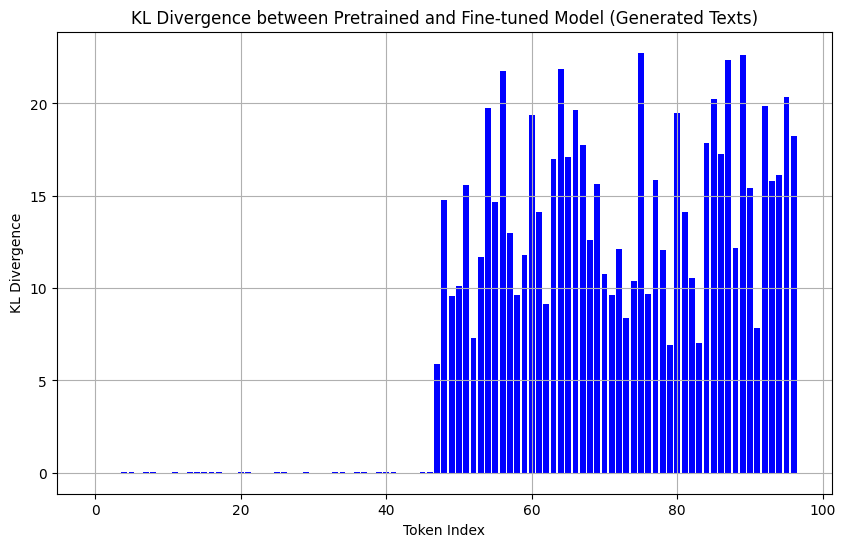

KL Divergences at each token: [-0.0011749267578125, 0.000972747802734375, 0.005401611328125, 0.0091552734375, 0.0113525390625, 0.01513671875, 0.000518798828125, 0.0128173828125, 0.0167236328125, 0.00421142578125, 0.00982666015625, 0.013916015625, -0.000583648681640625, 0.0224609375, 0.01141357421875, 0.02490234375, 0.0167236328125, 0.01806640625, 0.002777099609375, 0.00640869140625, 0.01806640625, 0.01116943359375, 0.00567626953125, 0.0062255859375, 0.00799560546875, 0.02587890625, 0.0211181640625, 0.0045166015625, 0.00555419921875, 0.01220703125, 0.01025390625, 0.0068359375, 0.00101470947265625, 0.020751953125, 0.017333984375, 0.004302978515625, 0.01336669921875, 0.01904296875, -0.00101470947265625, 0.0311279296875, 0.01513671875, 0.0145263671875, 0.0027008056640625, 0.00439453125, 0.0013885498046875, 0.0238037109375, 0.02099609375, 5.90625, 14.75, 9.5625, 10.125, 15.5625, 7.28125, 11.6875, 19.75, 14.6875, 21.75, 13.0, 9.625, 11.8125, 19.375, 14.125, 9.125, 17.0, 21.875, 17.125, 19.62

In [ ]:
import matplotlib.pyplot as plt

def analyze_kl_divergence_generated_text(prompt, base_model, fine_tuned_model, tokenizer):
    """Analyzes KL divergence at each token in the generated sequence."""

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(base_model.device)

    # Generate text from both models
    with torch.no_grad():
        base_generated = base_model.generate(
            inputs.input_ids, max_new_tokens=50, do_sample=True, temperature=0.7
        )
        finetuned_generated = fine_tuned_model.generate(
            inputs.input_ids, max_new_tokens=50, do_sample=True, temperature=0.7
        )

    # Decode the generated texts
    base_text = tokenizer.decode(base_generated[0], skip_special_tokens=True)
    finetuned_text = tokenizer.decode(finetuned_generated[0], skip_special_tokens=True)

    print("Base Model Output:", base_text)
    print("Fine-tuned Model Output:", finetuned_text)

    # Tokenize the generated texts
    base_inputs = tokenizer(base_text, return_tensors="pt").to("cuda")
    finetuned_inputs = tokenizer(finetuned_text, return_tensors="pt").to("cuda")

    # Get logits for generated tokens
    with torch.no_grad():
        base_outputs = base_model(**base_inputs)
        finetuned_outputs = fine_tuned_model(**finetuned_inputs)

    base_logits = base_outputs.logits
    finetuned_logits = finetuned_outputs.logits

    # Get the shorter sequence length
    min_seq_len = min(base_logits.shape[1], finetuned_logits.shape[1])

    # Truncate the logits tensors
    base_logits = base_logits[:, :min_seq_len, :]
    finetuned_logits = finetuned_logits[:, :min_seq_len, :]

    # Compute KL divergence at each token
    kl_divergences = []
    for i in range(base_logits.size(1)):
        kl = compute_kl_divergence(base_logits[:, i, :], finetuned_logits[:, i, :])
        kl_divergences.append(kl.item())

    print("LEN KL Divergence:", len(kl_divergences))

    # Plot the KL Divergence over the token sequence
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(kl_divergences)), kl_divergences, color='b')
    plt.title("KL Divergence between Pretrained and Fine-tuned Model (Generated Texts)")
    plt.xlabel("Token Index")
    plt.ylabel("KL Divergence")
    plt.grid(True)
    plt.show()

    return kl_divergences, inputs['input_ids']

# Example usage:
prompt = questions[1]
kl_divs, input_ids = analyze_kl_divergence_generated_text(prompt, base_model, model, base_tokenizer)

print("KL Divergences at each token:", kl_divs)


****************************************************************************************************
Doing patching for  q_proj
Capturing activations for layer: ['q_proj']
Patched model is ready. Run forward passes to analyze its behavior.
Base Model Output: A 5-day-old neonate is diagnosed with bacterial meningitis, and the causative organism is a gram-negative rod. What virulence factor is primarily responsible for this pathogen’s ability to cross the blood-brain barrier? The answer is an integer, without any units.

To what degree is the virulence factor primarily responsible for this pathogen’s ability to cross the blood-brain barrier? The answer is an integer, without any units.

The answer is an integer,
Fine-tuned Model Output: A 5-day-old neonate is diagnosed with bacterial meningitis, and the causative organism is a gram-negative rod. What virulence factor is primarily responsible for this pathogen’s ability to cross the blood-brain barrier? The answer should be...
</think>

A

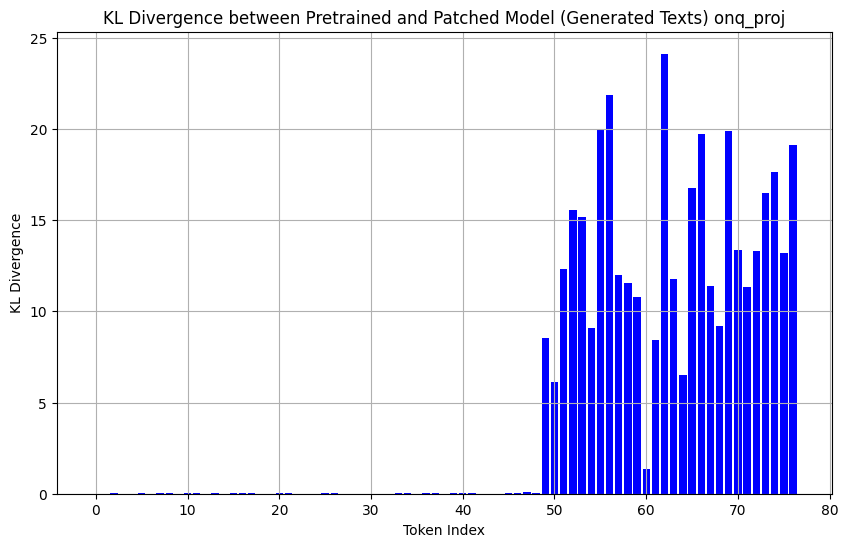

KL Divergences at each token: [0.00016021728515625, 0.0021209716796875, 0.0279541015625, 0.0048828125, 0.00946044921875, 0.01434326171875, 0.00167083740234375, 0.015380859375, 0.0157470703125, 0.002838134765625, 0.0142822265625, 0.0145263671875, 0.00396728515625, 0.02099609375, 0.009765625, 0.02001953125, 0.01397705078125, 0.021484375, 0.006103515625, 0.0040283203125, 0.0159912109375, 0.0155029296875, 0.00518798828125, 0.004180908203125, 0.006927490234375, 0.03271484375, 0.0247802734375, 0.00262451171875, 0.004119873046875, 0.01116943359375, 0.01171875, 0.0076904296875, 0.001007080078125, 0.019287109375, 0.015869140625, 0.0030975341796875, 0.01483154296875, 0.0203857421875, 0.0025177001953125, 0.0252685546875, 0.017333984375, 0.017822265625, 0.0003509521484375, 0.00183868408203125, 0.0031585693359375, 0.0283203125, 0.0203857421875, 0.0712890625, 0.01348876953125, 8.5625, 6.125, 12.3125, 15.5625, 15.1875, 9.0625, 20.0, 21.875, 12.0, 11.5625, 10.8125, 1.359375, 8.4375, 24.125, 11.75, 6.5

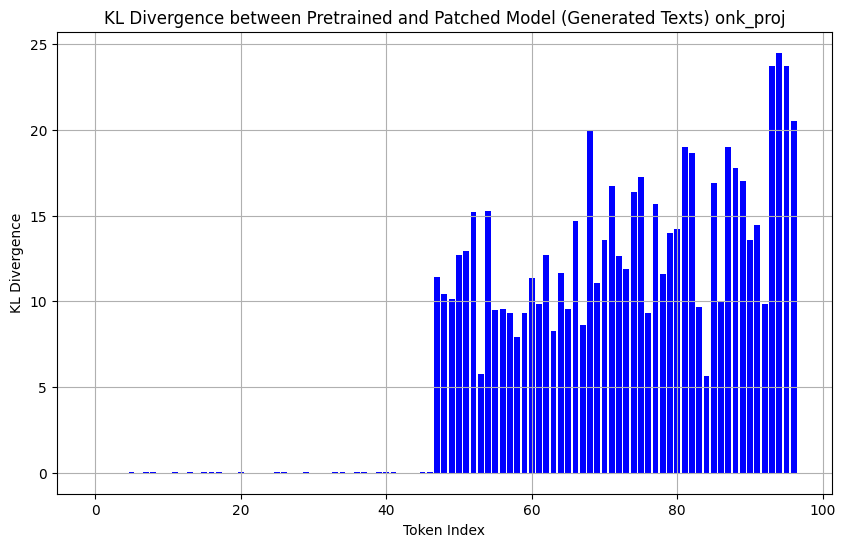

KL Divergences at each token: [-0.0011749267578125, 0.000972747802734375, 0.005401611328125, 0.0091552734375, 0.0113525390625, 0.01513671875, 0.000518798828125, 0.0128173828125, 0.0167236328125, 0.00421142578125, 0.00982666015625, 0.013916015625, -0.000583648681640625, 0.0224609375, 0.01141357421875, 0.02490234375, 0.0167236328125, 0.01806640625, 0.002777099609375, 0.00640869140625, 0.01806640625, 0.01116943359375, 0.00567626953125, 0.0062255859375, 0.00799560546875, 0.02587890625, 0.0211181640625, 0.0045166015625, 0.00555419921875, 0.01220703125, 0.01025390625, 0.0068359375, 0.00101470947265625, 0.020751953125, 0.017333984375, 0.004302978515625, 0.01336669921875, 0.01904296875, -0.00101470947265625, 0.0311279296875, 0.01513671875, 0.0145263671875, 0.0027008056640625, 0.00439453125, 0.0013885498046875, 0.0238037109375, 0.02099609375, 11.4375, 10.4375, 10.125, 12.6875, 12.9375, 15.1875, 5.78125, 15.25, 9.5, 9.5625, 9.3125, 7.9375, 9.3125, 11.375, 9.8125, 12.6875, 8.25, 11.625, 9.5625, 1

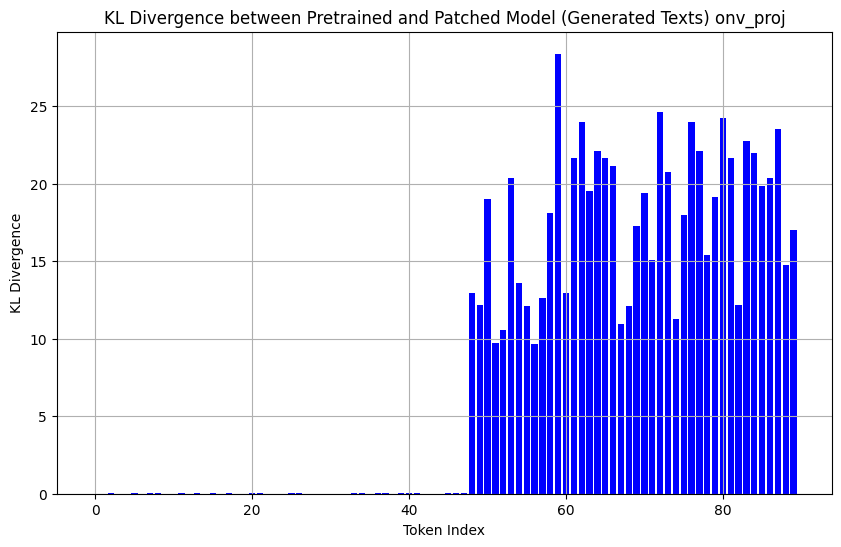

KL Divergences at each token: [0.00016021728515625, 0.0021209716796875, 0.0279541015625, 0.0048828125, 0.00946044921875, 0.01434326171875, 0.00167083740234375, 0.015380859375, 0.0157470703125, 0.002838134765625, 0.0142822265625, 0.0145263671875, 0.00396728515625, 0.02099609375, 0.009765625, 0.02001953125, 0.01397705078125, 0.021484375, 0.006103515625, 0.0040283203125, 0.0159912109375, 0.0155029296875, 0.00518798828125, 0.004180908203125, 0.006927490234375, 0.03271484375, 0.0247802734375, 0.00262451171875, 0.004119873046875, 0.01116943359375, 0.01171875, 0.0076904296875, 0.001007080078125, 0.019287109375, 0.015869140625, 0.0030975341796875, 0.01483154296875, 0.0203857421875, 0.0025177001953125, 0.0252685546875, 0.017333984375, 0.017822265625, 0.0003509521484375, 0.00183868408203125, 0.0031585693359375, 0.0283203125, 0.0203857421875, 0.0712890625, 12.9375, 12.1875, 19.0, 9.75, 10.5625, 20.375, 13.5625, 12.125, 9.6875, 12.625, 18.125, 28.375, 12.9375, 21.625, 24.0, 19.5, 22.125, 21.625, 2

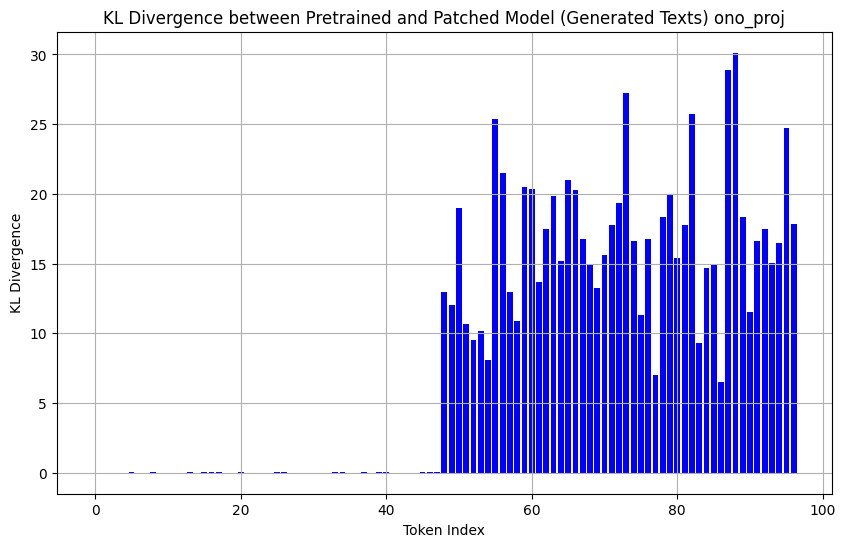

KL Divergences at each token: [-0.0011749267578125, 0.000972747802734375, 0.005401611328125, 0.0091552734375, 0.0113525390625, 0.01513671875, 0.000518798828125, 0.0128173828125, 0.0167236328125, 0.00421142578125, 0.00982666015625, 0.013916015625, -0.000583648681640625, 0.0224609375, 0.01141357421875, 0.02490234375, 0.0167236328125, 0.01806640625, 0.002777099609375, 0.00640869140625, 0.01806640625, 0.01116943359375, 0.00567626953125, 0.0062255859375, 0.00799560546875, 0.02587890625, 0.0211181640625, 0.0045166015625, 0.00555419921875, 0.01220703125, 0.01025390625, 0.0068359375, 0.00101470947265625, 0.020751953125, 0.017333984375, 0.004302978515625, 0.01336669921875, 0.01904296875, -0.00101470947265625, 0.0311279296875, 0.01513671875, 0.0145263671875, 0.0027008056640625, 0.00439453125, 0.0013885498046875, 0.0238037109375, 0.02099609375, 0.06591796875, 12.9375, 12.0625, 19.0, 10.6875, 9.5, 10.1875, 8.0625, 25.375, 21.5, 12.9375, 10.875, 20.5, 20.375, 13.6875, 17.5, 19.875, 15.1875, 21.0, 2

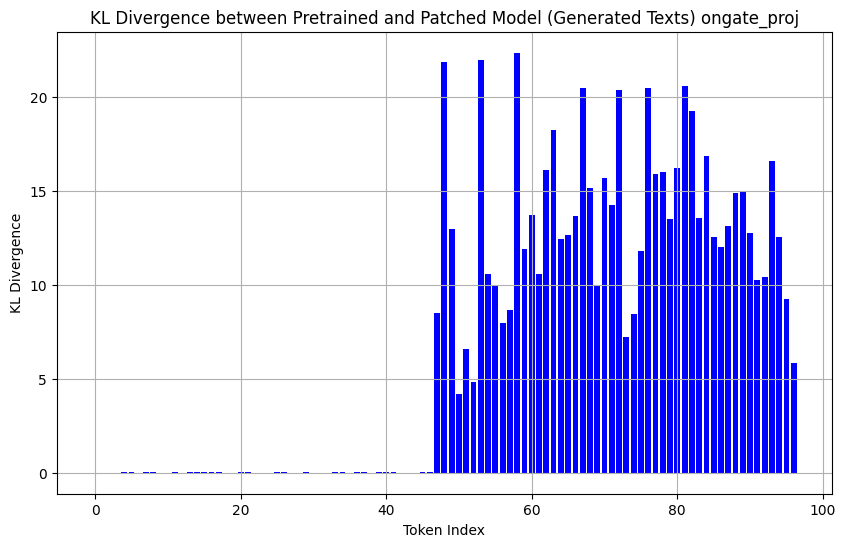

KL Divergences at each token: [-0.0011749267578125, 0.000972747802734375, 0.005401611328125, 0.0091552734375, 0.0113525390625, 0.01513671875, 0.000518798828125, 0.0128173828125, 0.0167236328125, 0.00421142578125, 0.00982666015625, 0.013916015625, -0.000583648681640625, 0.0224609375, 0.01141357421875, 0.02490234375, 0.0167236328125, 0.01806640625, 0.002777099609375, 0.00640869140625, 0.01806640625, 0.01116943359375, 0.00567626953125, 0.0062255859375, 0.00799560546875, 0.02587890625, 0.0211181640625, 0.0045166015625, 0.00555419921875, 0.01220703125, 0.01025390625, 0.0068359375, 0.00101470947265625, 0.020751953125, 0.017333984375, 0.004302978515625, 0.01336669921875, 0.01904296875, -0.00101470947265625, 0.0311279296875, 0.01513671875, 0.0145263671875, 0.0027008056640625, 0.00439453125, 0.0013885498046875, 0.0238037109375, 0.02099609375, 8.5, 21.875, 13.0, 4.21875, 6.59375, 4.8125, 22.0, 10.5625, 9.9375, 8.0, 8.6875, 22.375, 11.9375, 13.75, 10.5625, 16.125, 18.25, 12.4375, 12.6875, 13.6875

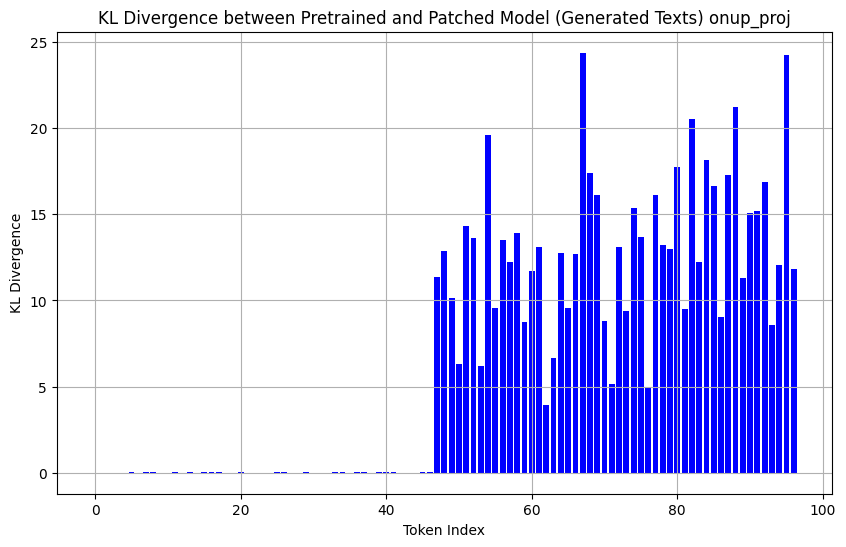

KL Divergences at each token: [-0.0011749267578125, 0.000972747802734375, 0.005401611328125, 0.0091552734375, 0.0113525390625, 0.01513671875, 0.000518798828125, 0.0128173828125, 0.0167236328125, 0.00421142578125, 0.00982666015625, 0.013916015625, -0.000583648681640625, 0.0224609375, 0.01141357421875, 0.02490234375, 0.0167236328125, 0.01806640625, 0.002777099609375, 0.00640869140625, 0.01806640625, 0.01116943359375, 0.00567626953125, 0.0062255859375, 0.00799560546875, 0.02587890625, 0.0211181640625, 0.0045166015625, 0.00555419921875, 0.01220703125, 0.01025390625, 0.0068359375, 0.00101470947265625, 0.020751953125, 0.017333984375, 0.004302978515625, 0.01336669921875, 0.01904296875, -0.00101470947265625, 0.0311279296875, 0.01513671875, 0.0145263671875, 0.0027008056640625, 0.00439453125, 0.0013885498046875, 0.0238037109375, 0.02099609375, 11.375, 12.875, 10.125, 6.3125, 14.3125, 13.625, 6.1875, 19.625, 9.5625, 13.5, 12.25, 13.9375, 8.75, 11.6875, 13.125, 3.953125, 6.65625, 12.75, 9.5625, 12

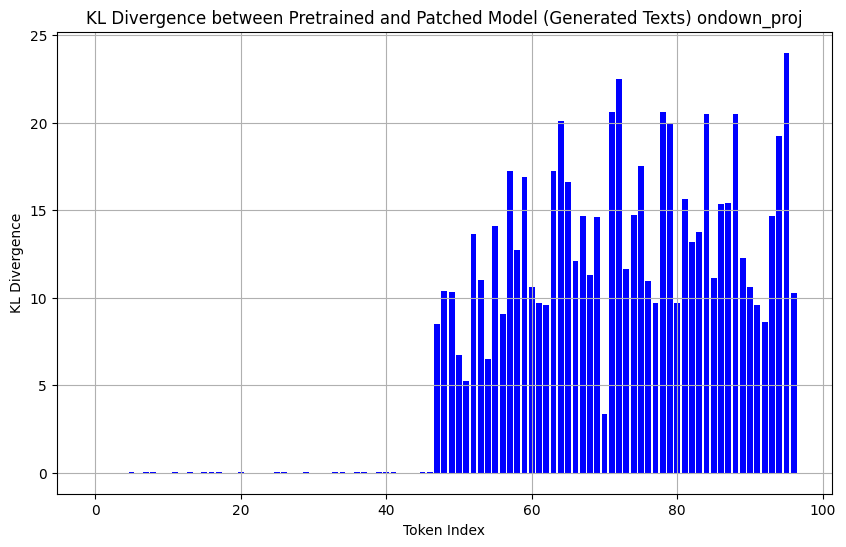

KL Divergences at each token: [-0.0011749267578125, 0.000972747802734375, 0.005401611328125, 0.0091552734375, 0.0113525390625, 0.01513671875, 0.000518798828125, 0.0128173828125, 0.0167236328125, 0.00421142578125, 0.00982666015625, 0.013916015625, -0.000583648681640625, 0.0224609375, 0.01141357421875, 0.02490234375, 0.0167236328125, 0.01806640625, 0.002777099609375, 0.00640869140625, 0.01806640625, 0.01116943359375, 0.00567626953125, 0.0062255859375, 0.00799560546875, 0.02587890625, 0.0211181640625, 0.0045166015625, 0.00555419921875, 0.01220703125, 0.01025390625, 0.0068359375, 0.00101470947265625, 0.020751953125, 0.017333984375, 0.004302978515625, 0.01336669921875, 0.01904296875, -0.00101470947265625, 0.0311279296875, 0.01513671875, 0.0145263671875, 0.0027008056640625, 0.00439453125, 0.0013885498046875, 0.0238037109375, 0.02099609375, 8.5, 10.375, 10.3125, 6.75, 5.25, 13.625, 11.0, 6.5, 14.125, 9.0625, 17.25, 12.75, 16.875, 10.625, 9.6875, 9.5625, 17.25, 20.125, 16.625, 12.125, 14.6875,

In [ ]:
import torch
from functools import partial

def capture_activations(model, inputs, target_layers):
    """Captures activations from specified layers."""
    activations = {}

    def hook_fn(module, input, output, layer_name):
        activations[layer_name] = output.detach()

    hooks = []
    for name, module in model.named_modules():
        if name in target_layers:
            hook = module.register_forward_hook(partial(hook_fn, layer_name=name))
            hooks.append(hook)

    with torch.no_grad():
        model(**inputs)

    for hook in hooks:
        hook.remove()

    return activations

def patch_activations(fine_tuned_model, base_activations, target_layers):
    """Patches activations in the fine-tuned model and returns the modified model."""

    def patch_hook_fn(module, input, output, layer_name):
        return base_activations[layer_name]  # Replace output with base activations

    hooks = []
    for name, module in fine_tuned_model.named_modules():
        if name in target_layers:
            hook = module.register_forward_hook(partial(patch_hook_fn, layer_name=name))
            hooks.append(hook)

    return fine_tuned_model, hooks  # Return the patched model and hooks

# Example Usage:

prompt = questions[1]  # Or your chosen prompt

# Step 1: Generate text from the base model
base_gen_ids = base_model.generate(**tokenizer(prompt, return_tensors="pt").to(base_model.device), max_new_tokens=50)
generated_inputs = {"input_ids": base_gen_ids, "attention_mask": torch.ones_like(base_gen_ids)}

# Step 2: Capture activations
layer_names = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

kl_div_dict = {}

for target_layer in layer_names:

    print("*"*100)

    print("Doing patching for ", target_layer)

    target_layers = [target_layer]
    print(f"Capturing activations for layer: {target_layers}")
    base_activations = capture_activations(base_model, generated_inputs, target_layers)

    # Step 3: Patch activations in the fine-tuned model
    patched_model, hooks = patch_activations(model, base_activations, target_layers)

    # Step 4: Return the patched model (You can now run forward passes manually)
    print("Patched model is ready. Run forward passes to analyze its behavior.")

    import matplotlib.pyplot as plt

    def analyze_kl_divergence_generated_text(prompt, base_model, fine_tuned_model, tokenizer):
        """Analyzes KL divergence at each token in the generated sequence."""

        # Tokenize the prompt
        inputs = tokenizer(prompt, return_tensors="pt").to(base_model.device)

        # Generate text from both models
        with torch.no_grad():
            base_generated = base_model.generate(
                inputs.input_ids, max_new_tokens=50, do_sample=True, temperature=0.7
            )
            finetuned_generated = fine_tuned_model.generate(
                inputs.input_ids, max_new_tokens=50, do_sample=True, temperature=0.7
            )

        # Decode the generated texts
        base_text = tokenizer.decode(base_generated[0], skip_special_tokens=True)
        finetuned_text = tokenizer.decode(finetuned_generated[0], skip_special_tokens=True)

        print("Base Model Output:", base_text)
        print("Fine-tuned Model Output:", finetuned_text)

        # Tokenize the generated texts
        base_inputs = tokenizer(base_text, return_tensors="pt").to("cuda")
        finetuned_inputs = tokenizer(finetuned_text, return_tensors="pt").to("cuda")

        # Get logits for generated tokens
        with torch.no_grad():
            base_outputs = base_model(**base_inputs)
            finetuned_outputs = fine_tuned_model(**finetuned_inputs)

        base_logits = base_outputs.logits
        finetuned_logits = finetuned_outputs.logits

        # Get the shorter sequence length
        min_seq_len = min(base_logits.shape[1], finetuned_logits.shape[1])

        # Truncate the logits tensors
        base_logits = base_logits[:, :min_seq_len, :]
        finetuned_logits = finetuned_logits[:, :min_seq_len, :]

        # Compute KL divergence at each token
        kl_divergences = []
        for i in range(base_logits.size(1)):
            kl = compute_kl_divergence(base_logits[:, i, :], finetuned_logits[:, i, :])
            kl_divergences.append(kl.item())

        print("LEN KL Divergence:", len(kl_divergences))

        # Plot the KL Divergence over the token sequence
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(kl_divergences)), kl_divergences, color='b')
        title = "KL Divergence between Pretrained and Patched Model (Generated Texts) on" + target_layer
        plt.title(title)
        plt.xlabel("Token Index")
        plt.ylabel("KL Divergence")
        plt.grid(True)
        plt.show()

        return kl_divergences, inputs['input_ids']

    # Example usage:
    prompt = questions[1]
    kl_divs, input_ids = analyze_kl_divergence_generated_text(prompt, base_model, patched_model, base_tokenizer)

    print("KL Divergences at each token:", kl_divs)

    inputs = tokenizer(prompt, return_tensors="pt").to(base_model.device)

    with torch.no_grad():
        base_generated = base_model.generate(
            inputs.input_ids, max_new_tokens=50, do_sample=True, temperature=0.7
        )
        finetuned_generated = patched_model.generate(
            inputs.input_ids, max_new_tokens=50, do_sample=True, temperature=0.7
        )

    base_text = tokenizer.decode(base_generated[0], skip_special_tokens=True)
    finetuned_text = tokenizer.decode(finetuned_generated[0], skip_special_tokens=True)

    print("Base Model Output:", base_text)
    print("Fine-tuned Model Output:", finetuned_text)

    # Tokenize generated text
    base_inputs = tokenizer(base_text, return_tensors="pt").to("cuda")
    finetuned_inputs = tokenizer(finetuned_text, return_tensors="pt").to("cuda")

    # Get logits for generated tokens
    with torch.no_grad():
        base_outputs = base_model(**base_inputs)
        finetuned_outputs = patched_model(**finetuned_inputs)

    base_logits = base_outputs.logits
    finetuned_logits = finetuned_outputs.logits

    # Get the shorter sequence length
    min_seq_len = min(base_logits.shape[1], finetuned_logits.shape[1])

    # Truncate the logits tensors
    base_logits = base_logits[:, :min_seq_len, :]
    finetuned_logits = finetuned_logits[:, :min_seq_len, :]


    kl_value = compute_kl_divergence(base_logits, finetuned_logits)
    print(f"KL Divergence (Generated Tokens): {kl_value.item()}")

    kl_div_dict[target_layer] = kl_value.item()

    print("*"*100)

    print("Done")

    print("#"*100)